In [2]:
import pandas as pd

In [3]:
def get_data(path): return pd.read_csv(
    path, sep=';', index_col='timestamp', parse_dates=True)


data_frames = {
    'monday': get_data('./data/monday.csv'),
    'tuesday': get_data('./data/tuesday.csv'),
    'wednesday': get_data('./data/wednesday.csv'),
    'thursday':  get_data('./data/thursday.csv'),
    'friday': get_data('./data/friday.csv')
}


In [4]:
df = None
for key in data_frames:
    current_df = data_frames[key]
    current_df['customer_no'] = current_df['customer_no'].map(lambda x: f'{key}_{x}')
    
    if df is None:
        df = current_df
    else: 
        df = pd.concat([df , current_df])
df
    

,customer_no,location
timestamp,,
2019-09-02 07:03:00,monday_1,dairy
2019-09-02 07:03:00,monday_2,dairy
2019-09-02 07:04:00,monday_3,dairy
2019-09-02 07:04:00,monday_4,dairy
2019-09-02 07:04:00,monday_5,spices
...,...,...
2019-09-06 21:50:00,friday_1500,dairy
2019-09-06 21:50:00,friday_1507,checkout
2019-09-06 21:50:00,friday_1508,checkout


# Add time elements to the dataframe

In [5]:
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['day_number'] = df.index.day
df['day'] = df.index.day_name()
df


,customer_no,location,hour,minute,day_number,day
timestamp,,,,,,
2019-09-02 07:03:00,monday_1,dairy,7,3,2,Monday
2019-09-02 07:03:00,monday_2,dairy,7,3,2,Monday
2019-09-02 07:04:00,monday_3,dairy,7,4,2,Monday
2019-09-02 07:04:00,monday_4,dairy,7,4,2,Monday
2019-09-02 07:04:00,monday_5,spices,7,4,2,Monday
...,...,...,...,...,...,...
2019-09-06 21:50:00,friday_1500,dairy,21,50,6,Friday
2019-09-06 21:50:00,friday_1507,checkout,21,50,6,Friday
2019-09-06 21:50:00,friday_1508,checkout,21,50,6,Friday


In [6]:
# df[df['day']].describe()

## Total number of customers in each section

In [7]:
df.groupby('location').count()


,customer_no,hour,minute,day_number,day
location,,,,,
checkout,7417,7417,7417,7417,7417
dairy,4679,4679,4679,4679,4679
drinks,3905,3905,3905,3905,3905
fruit,5122,5122,5122,5122,5122
spices,3754,3754,3754,3754,3754


## Total number of customers in each section over time

In [8]:
df.groupby(['location', 'hour']).count()


customer_no  minute  day_number  day
location hour                                      
checkout 7             454     454         454  454
         8             677     677         677  677
         9             455     455         455  455
         10            427     427         427  427
         11            342     342         342  342
...                    ...     ...         ...  ...
spices   17            269     269         269  269
         18            346     346         346  346
         19            389     389         389  389
         20            246     246         246  246
         21            122     122         122  122

[75 rows x 4 columns]

# Total amount of customers in the store at any given time

In [9]:
minute_location_df = df.groupby([ 'day', 'hour', 'minute' ]).count()
# minute_location_df.to_csv('./data/amount_of_customers_at_time.csv')
# minute_location_df.index.names
# minute_location_df.reset_index()
minute_location_df
# minute_location_df.loc['Tuesday', 12, 9]['customer_no']

customer_no  location  day_number
day       hour minute                                   
Friday    7    0                 3         3           3
               1                 3         3           3
               2                 3         3           3
               3                 3         3           3
               4                 3         3           3
...                            ...       ...         ...
Wednesday 21   45                5         5           5
               46                4         4           4
               47                4         4           4
               48                3         3           3
               49                4         4           4

[4363 rows x 3 columns]

In [10]:
locations = df['location'].unique()
locations

array(['dairy', 'spices', 'fruit', 'checkout', 'drinks'], dtype=object)

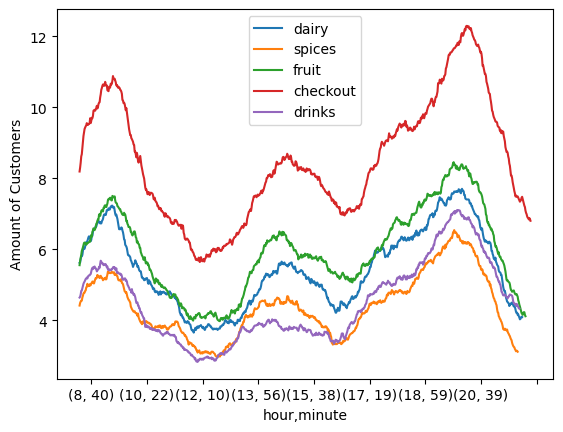

In [11]:
# minute_location_df[minute_location_df['location'] == 'checkout']['minute'].rolling(1000).mean().plot()
for location in locations:
    df.query(f'location == "{location}"') \
    .groupby(['hour', 'minute']) \
    .count()['customer_no'] \
    .rolling(80) \
    .mean() \
    .plot(label=location, ylabel='Amount of Customers',legend=True)


## Time each customer spent in the market

In [12]:
def get_customer_time_in_market_for_day(name, cus_df):
    max_hour = cus_df['hour'].max()
    min_hour = cus_df['hour'].min()
    max_minute = cus_df['minute'].max()
    min_minute = cus_df['minute'].min()
    mins_in_market = max_minute - min_minute
    hour_in_market = max_hour - min_hour
    hour_in_market = max_hour - min_hour
    first_stop = cus_df.iloc[0]['location']
    following_stop = None
    try:
        following_stop = cus_df.iloc[1]
    except IndexError:
        pass

    return_df = pd.DataFrame({
        'customer_no': [name],
        'time_in_market_mins': [hour_in_market * 60 + mins_in_market],
        'first_stop': [first_stop],
        'following_stop': [following_stop['location'] if following_stop is not None else None]
    }).set_index('customer_no')
    return return_df


customers_gr = df.groupby('customer_no')


customers_df = None
for name, custom_df in customers_gr:
    current_df = get_customer_time_in_market_for_day(name, custom_df)
    if customers_df is None:
        customers_df = current_df
    else:
        customers_df = pd.concat([customers_df, current_df])


## Total number of customers in the supermarket over time

### Over a day

,time_in_market_mins,first_stop,following_stop
customer_no,,,
friday_1,5,dairy,spices
friday_10,5,fruit,checkout
friday_100,1,fruit,checkout
friday_1000,1,fruit,checkout
friday_1001,10,fruit,drinks
...,...,...,...
wednesday_995,112,fruit,dairy
wednesday_996,110,fruit,dairy
wednesday_997,105,dairy,spices


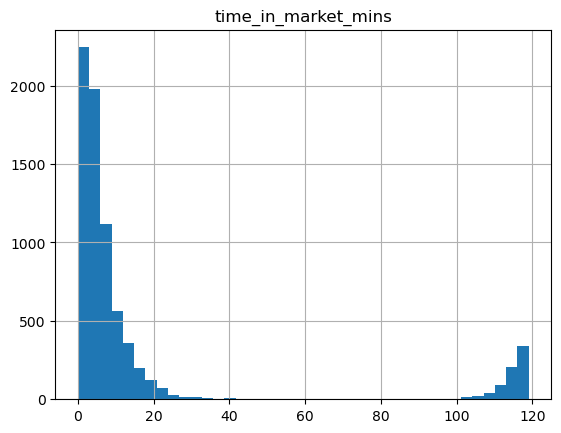

In [13]:
customers_df.hist(bins=40)
customers_df

### Over a week

<AxesSubplot:xlabel='day'>

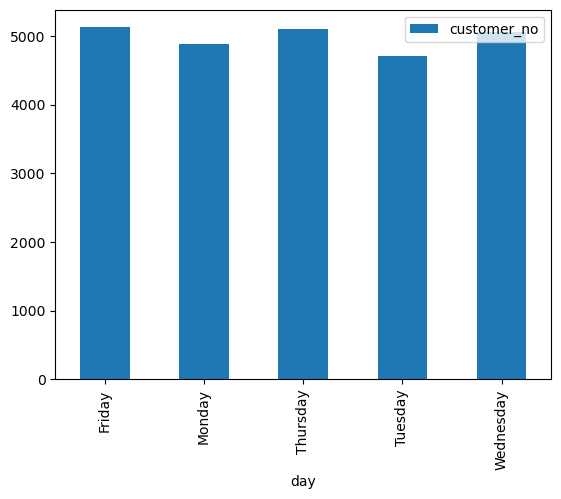

In [14]:
customers_gr = df.groupby('day').count()

min_val = customers_gr[['customer_no']].min()
max_val = customers_gr[['customer_no']].max()
customers_gr[['customer_no']].plot.bar()


##  The distribution of customers of their first visited section versus following sections

<AxesSubplot:xlabel='first_stop,following_stop'>

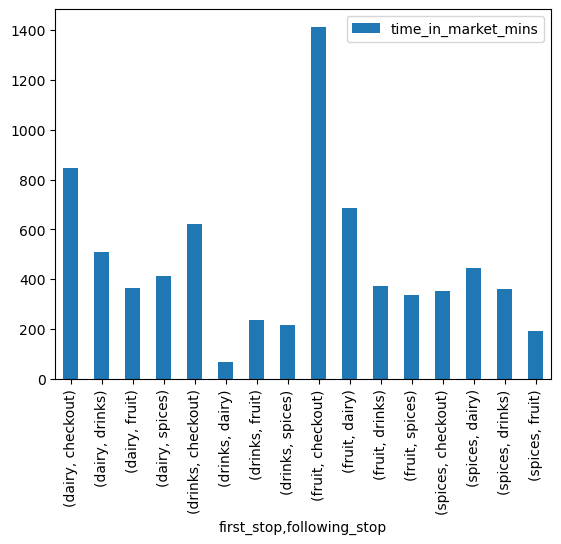

In [15]:
# customers_df.groupby(['first_stop', 'following_stop']).plot.bar()
to_plot_df = customers_df.groupby(['first_stop', 'following_stop']).count()

to_plot_df.plot.bar()


In [16]:
df.reset_index().iloc[-1]['timestamp']

Timestamp('2019-09-06 21:50:00')

## Get Markov Probabilities

In [17]:
def get_next_step(name, cus_df):
    ## Add the first step
    
    cus_df = pd.concat([
        pd.DataFrame({
            'timestamp': [cus_df.reset_index().iloc[-1]['timestamp'] -pd.Timedelta(minutes=1)],
            'customer_no': [name],
            'location': ['entrance'],
        }).set_index('timestamp'),
        
        custom_df,   
        
    ])
    
    
    cus_df['next_location'] = cus_df['location'].shift(-1)

    if len(cus_df[cus_df['location'] == 'checkout']) == 0:
        cus_df = pd.concat([
            
            custom_df,   
            
            pd.DataFrame({
                'timestamp': [cus_df.reset_index().iloc[-1]['timestamp'] + pd.Timedelta(minutes=1)],
                'customer_no': [name],
                'location': ['checkout'],
                'next_location': ['exit']
            }).set_index('timestamp')
        ])
        
    else:

        cus_df.loc[cus_df['location'] == 'checkout', 'next_location'] = 'exit'
    return cus_df


In [18]:

next_locations_df = None
for name, custom_df in df.drop(['hour','minute','day'], axis=1).groupby('customer_no'):
    current_df = get_next_step(name, custom_df)
    if next_locations_df is None:
        next_locations_df = current_df
    else:
        next_locations_df = pd.concat([next_locations_df, current_df])


In [19]:
next_locations_df.to_csv('./data/customer_transitions.csv')

# Can start from here after dataframe has been saved to file

In [20]:
import pandas as pd
next_locations_df = pd.read_csv('./data/customer_transitions.csv')

In [21]:
next_locations_df[next_locations_df['location'] =='entrance']



,timestamp,customer_no,location,day_number,next_location
0,2019-09-06 07:04:00,friday_1,entrance,NaN,dairy
4,2019-09-06 07:10:00,friday_10,entrance,NaN,fruit
7,2019-09-06 08:03:00,friday_100,entrance,NaN,fruit
10,2019-09-06 17:19:00,friday_1000,entrance,NaN,fruit
13,2019-09-06 17:28:00,friday_1001,entrance,NaN,fruit
...,...,...,...,...,...
32298,2019-09-04 17:19:00,wednesday_995,entrance,NaN,fruit
32304,2019-09-04 17:02:00,wednesday_996,entrance,NaN,fruit
32308,2019-09-04 17:13:00,wednesday_997,entrance,NaN,dairy
32315,2019-09-04 16:58:00,wednesday_998,entrance,NaN,dairy


In [22]:
P = pd.crosstab(
    next_locations_df['location'], 
    next_locations_df['next_location'], normalize='index')
P

next_location,checkout,dairy,drinks,exit,fruit,spices
location,,,,,,
checkout,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
dairy,0.392389,0.000000,0.222318,0.0,0.189852,0.195442
drinks,0.538956,0.027256,0.000000,0.0,0.217794,0.215994
entrance,0.000000,0.286639,0.153566,0.0,0.378050,0.181745
fruit,0.500784,0.236966,0.136417,0.0,0.000000,0.125833
spices,0.251672,0.323616,0.272800,0.0,0.151912,0.000000


In [1]:
import seaborn as sns
sns.heatmap(P.corr())


NameError: name 'P' is not defined

In [18]:
for k, row in P.iterrows():
    row_sum = sum(row)
    assert round(row_sum, 5) == 1, f'The sum of row was {row_sum}'

## Create choice probabilities

In [19]:
probs_dict = P.to_dict(orient='index')
# probs_dict

In [20]:
# convert internal values, which is a dict to a list
probs = {}
for key in probs_dict.keys():
    probs[key] = list(probs_dict[key].values())
# probs

## Make simulation

In [21]:

import random

current_state = 'entrance'
states = list(probs_dict[current_state].keys())
states

print(current_state)
print(states)
# print(probs.keys())
print(probs[current_state])
# print(probs)


random.choices(states, weights=probs[current_state])[0]


entrance
['checkout', 'dairy', 'drinks', 'exit', 'fruit', 'spices']
[0.0, 0.2866388027504382, 0.15356613185924228, 0.0, 0.3780504247000135, 0.18174464069030605]


'fruit'

In [22]:

# while current_state != 'exit':
print('Customer at', current_state)
state_probs = probs[current_state]

choices = list(probs_dict[current_state].keys())
current_state = random.choices(choices, weights=state_probs)[0]



Customer at entrance


In [23]:
import numpy as np

initial_state = np.array([1,	0,	0,	0,	0,	0])
np.dot(initial_state, P)

array([0., 0., 0., 1., 0., 0.])

In [24]:
import random

TILE_SIZE = 32

class Customer:
    """
    a single customer that moves through the supermarket
    in a MCMC simulation
    """
    def __init__(self, name, supermarket, avatar_id, row=0, col=0, initial_state='entrance'):
        """
        supermarket: A SuperMarketMap object
        avatar : a numpy array containing a 32x32 tile image
        row: the starting row
        col: the starting column
        """
    
        self.name = name
        self.state = initial_state
        
        ## Properties for animation
        self.supermarket = supermarket
        self.avatar = supermarket.get_tile(avatar_id) 
        self.row = row
        self.col = col

    
    def __repr__(self):
        return f'<Customer {self.name} in {self.state} {id(self)}>'

    def next_state(self, probs_dict):
        '''
        Propagates the customer to the next state.
        Returns nothing.
        '''
        
        probs_arr = {}
        
        for key in probs_dict.keys():
            probs_arr[key] = list(probs_dict[key].values())
           
        next_location_choices = list(probs_dict[self.state].keys())
                
        probability_weights = probs_arr[self.state]
                
        self.state = random.choices(next_location_choices, weights=probability_weights)[0]
        return self.state
    
      
    def draw(self, frame):

        y = self.row * TILE_SIZE
        x = self.col * TILE_SIZE

        one = y + self.avatar.shape[0]
        two = x + self.avatar.shape[1]

        frame[y:one, x:two] = self.avatar

        return frame
    
    def move(self, location):
        assert(type(location) is tuple)
        new_row = location[0]
        new_col = location[1]

        if self.supermarket.contents[new_row][new_col] == '.':
            self.col = new_col
            self.row = new_row

In [25]:
class Sections:
    
    def __init__(self, dairy, drinks, spices, fruit, checkout):
        assert type(dairy) is list
        assert type(checkout) is list
        assert type(drinks) is list
        assert type(spices) is list
        assert type(fruit) is list
        
        self.dairy = dairy
        self.drinks = drinks
        self.spices = spices
        self.fruit = fruit
        self.checkout = checkout

In [26]:

class SuperMarket:
    
    def __init__(self, name, transition_matrix, map, sections):
        self.name = name
        self.map = map
        
        assert name != None, 'The name should have a value'
        assert transition_matrix != None, 'There should be a transition_matrix on construction'
        assert sections != None, 'There should be a section on construction'
        
        self.customers = []
        self.total_visits = 0
        
        self.transition_matrix = transition_matrix
        self.sections = sections
        
        self.probs_dict = transition_matrix.to_dict(orient='index')
        self.probs_arr = {}
        
        for key in self.probs_dict.keys():
            self.probs_arr[key] = list(self.probs_dict[key].values())
            
    
    def __repr__(self):
        return f'<SuperMarket {self.name}>'
    
    
    def add_customers(self, new_customers: list):
        self.total_visits += 1
        self.customers = [*self.customers, *new_customers]
        
        
    def remove_customers(self, customer_arr):
        for customer in customer_arr:
            self.customers.remove(customer)
        
        
    def tick_minute(self):
        current_status = [ ]
        
        for customer in self.customers:
            
            new_customer_state = customer.next_state(self.probs_dict)
            
            if new_customer_state == 'exit':
                # print('Removing customer with state', new_customer_state)
                self.remove_customers([customer])
                
            current_status = [*current_status, { 'id': customer.name, 'state': new_customer_state }]
                
        return current_status

In [27]:
from faker import Faker
from tiles_skeleton import SupermarketMap, MARKET
import cv2

faker = Faker()

time_simulation_in_minutes = 30
max_customers = 10

background = np.zeros((500, 700, 3), np.uint8)
tiles = cv2.imread(f"{dir}/tiles.png")

sections = Sections(
    dairy=[],
    spices=[],
    drinks=[],
    fruit=[],
    checkout=[(4, 8) , (8, 8) , (12, 8)]
)




[ WARN:0@69.436] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('<built-in function dir>/tiles.png'): can't open/read file: check file path/integrity


In [28]:
supermarket_map = SupermarketMap(MARKET, tiles)

TypeError: 'NoneType' object is not subscriptable

In [8]:
supermarket = SuperMarket('REWE', P, super_market_map, sections)


NameError: name 'SuperMarket' is not defined

In [ ]:


for minute in range(0, time_simulation_in_minutes):
    
    total_visits = supermarket.total_visits
    
    supermarket.add_customers([  
            Customer(str(f'{faker.name()} ID:{i}'), supermarket.map, '1')                     \
            for i \
                in range(
                        total_visits,
                        random.randint(
                                total_visits + 1 ,
                                total_visits + 1 + max_customers 
                            )
                    )
        ])

    customer_states = supermarket.tick_minute()
    # print(f'Minute{minute} \n{customer_states}\n')
    
    while True:
        frame = background.copy()
        supermarket.map.draw(frame)

        # https://www.ascii-code.com/
        key = cv2.waitKey(1)
        
        if key == 113: # 'q' key
            break

        cv2.imshow("frame", frame)


    cv2.destroyAllWindows()

    # market.write_image("supermarket.png")


In [94]:
# !pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 12.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
